# Project: Advanced Lane Finding

## Camera calibration

In [22]:
import os
import math
import time
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

camera_cal_images = []
def camera_cal():
    # prepare object points
    nx = 9 #TODO: enter the number of inside corners in x
    ny = 6 #TODO: enter the number of inside corners in y
    winSize = (nx, ny)
    count = 0

    # nx*ny object points,  (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)#生成棋盘网格中每个点的坐标

    # Arrays to store object points and image points from all the images.
    objpoints = [] # points in real world space, 3d 
    imgpoints = [] # points in image plane, 2d

    # Make a list of calibration images
    os.listdir("camera_cal/")
    for filename in os.listdir("camera_cal/"):
        image = mpimg.imread("camera_cal/"+filename)
        camera_cal_images.append(image)
        img_size = (image.shape[1], image.shape[0])
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)       
        if ret == True:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            cv2.cornerSubPix(gray, corners, winSize, (-1,-1), criteria)
            # save for calibration
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display corners
            cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
            plt.imshow(image)
        time.sleep(0.1)    
        count += 1
    # Apply calibration 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    file = open('camera_calib_matrix.dat', 'wb')
    pickle.dump( dist_pickle, file )
    file.close()                
    return ret, mtx, dist, rvecs, tvecs

def undist_image(image, mtx, dist, rvecs, tvecs, show=False):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    result = cv2.hconcat([image, dst])
    cv2.imwrite('output_images/undistort_output.png',result)

    if show==True:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(image)
        ax1.set_title('Original', fontsize=15)
        ax2.imshow(dst)
        ax2.set_title('Undist', fontsize=15) 
        #plt.show()
def perspective_image(image):
    return image


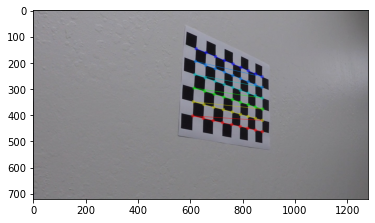

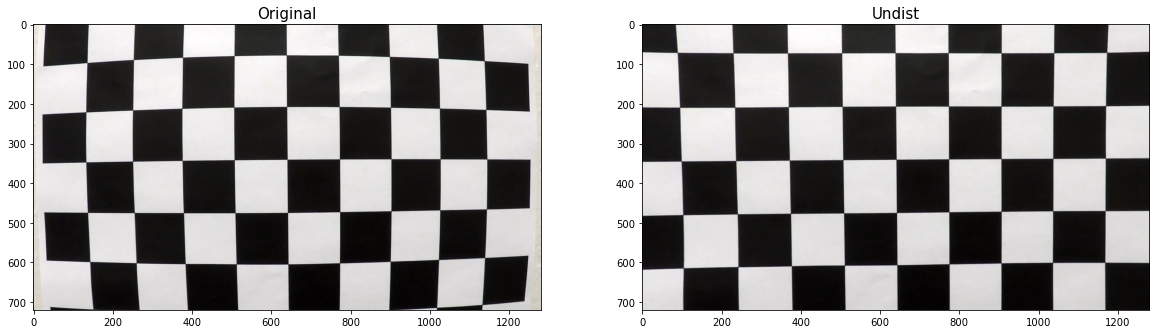

In [24]:

# calibrate camera from images
ret, mtx, dist, rvecs, tvecs = camera_cal()
# if success, undistort a sample image and show
undist_image(camera_cal_images[0], mtx, dist, rvecs, tvecs, True)

# different way to extract edge from image 

In [42]:
# Sobel function for edge of x or y, 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:    
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output

# magnide edge based on sobel
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    mag_sobelx = cv2.multiply(sobelx, sobelx)
    mag_sobely = cv2.multiply(sobely, sobely)
    mag_sobel = cv2.sqrt(mag_sobelx+mag_sobely)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_img = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(sobel_img)
    sbinary[(sobel_img>=mag_thresh[0]) & (sobel_img<=mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary
    return binary_output

# edge by direction on sobel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(sobel_direction)
    sbinary[(sobel_direction>=thresh[0]) & (sobel_direction<=thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sbinary # Remove this line
    return binary_output

# lane thresh from color space
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    h, l, s = cv2.split(hls)
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# define detect function to combined all together
def get_combined(image, ksize):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))  # sobel on x
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))  # sobel on y
    grad_sobel = (gradx==1) & (grady==1)  # sobel together
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100)) # mag
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) # direction
    hls_binary = hls_select(image, thresh=(90, 255))  # on HLS color
    
    combined = np.zeros_like(dir_binary)
    combined[(grad_sobel==1) | (hls_binary==1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

Text(0.5, 1.0, 'result')

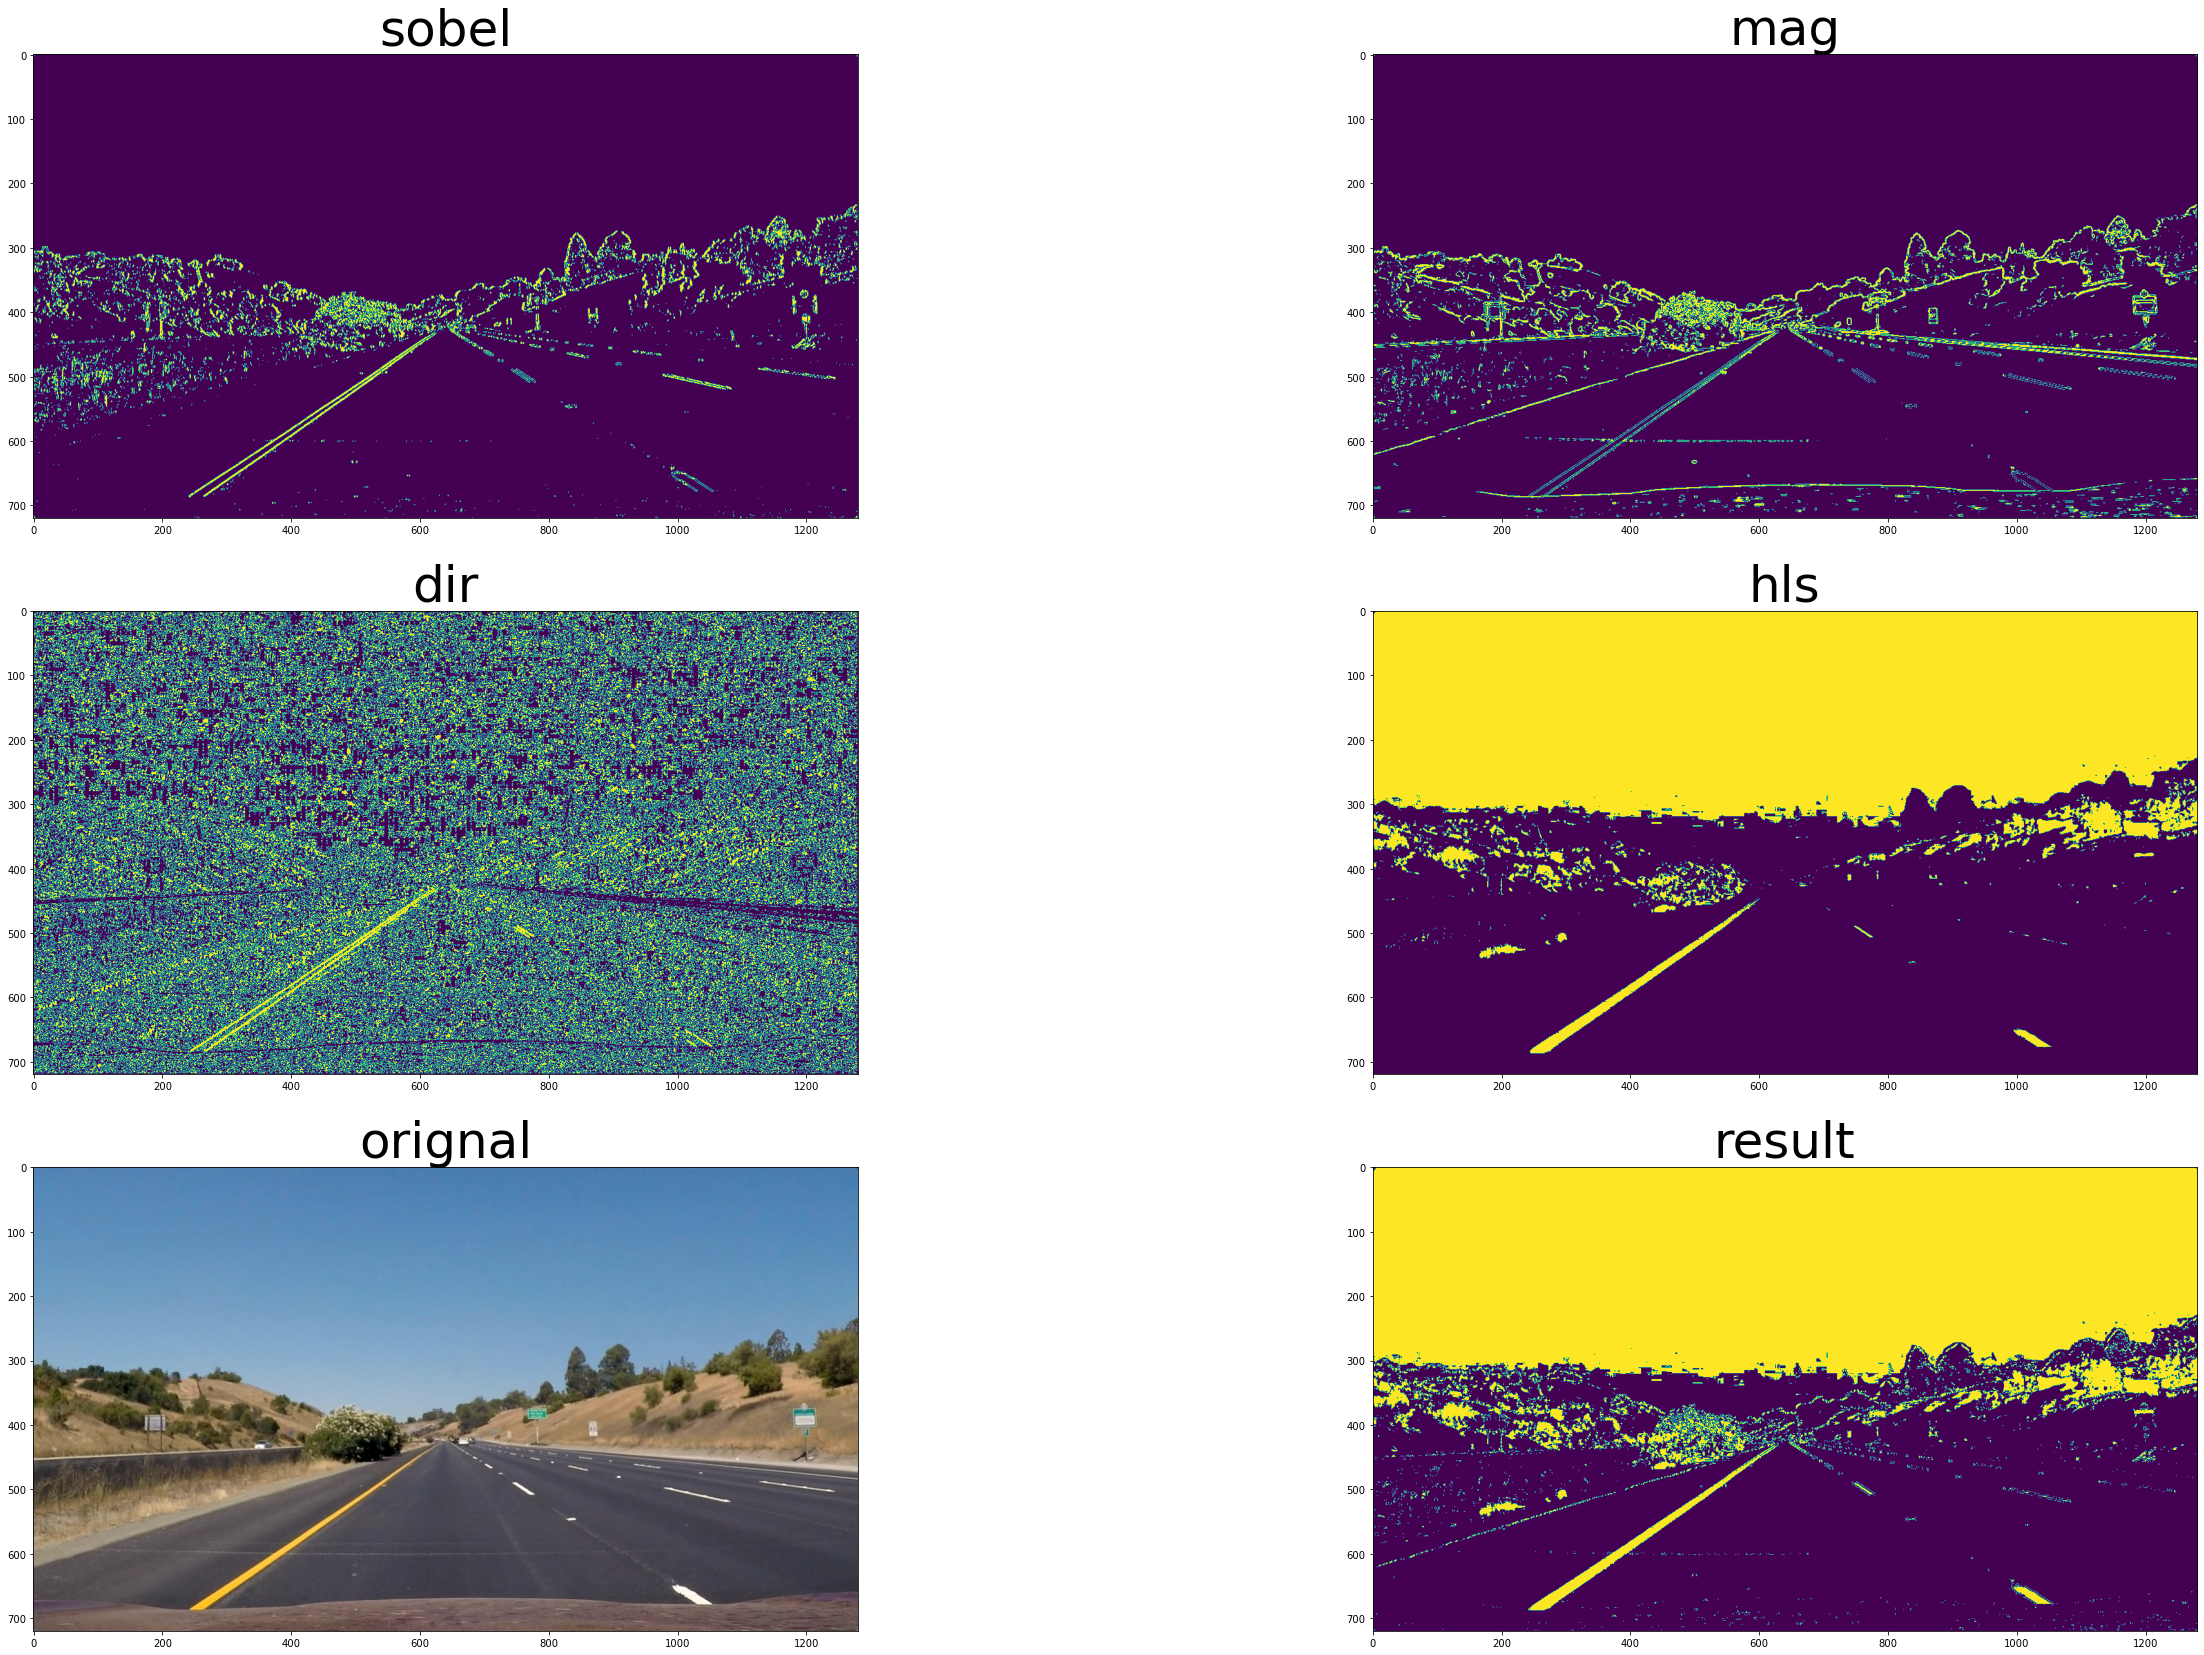

In [71]:
# test on image    
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Read in an image and grayscale it
test_images = [mpimg.imread('test_images/' + i) for i in os.listdir('test_images/')]
image = test_images[0]

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))  # sobel on x
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))  # sobel on y
grad_sobel = (gradx==1) & (grady==1)  # sobel together
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100)) # mag
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3)) # direction
hls_binary = hls_select(image, thresh=(90, 255))  # on HLS color

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(44, 29))
ax1.imshow(gradx)
ax1.set_title('sobel', fontsize=50)
ax2.imshow(mag_binary)
ax2.set_title("mag", fontsize=50)
ax3.imshow(dir_binary)
ax3.set_title("dir", fontsize=50)
ax4.imshow(hls_binary)
ax4.set_title('hls', fontsize=50)

combined = np.zeros_like(dir_binary)
combined[(grad_sobel==1) | (hls_binary==1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
ax5.imshow(image)
ax5.set_title("orignal", fontsize=50)
ax6.imshow(combined)
ax6.set_title("result", fontsize=50)

In [72]:
# region function from previsous chapter
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Defining vertices for marked area定义感兴趣区域,将左右两条车道线的区域框出来
def get_lane_mask(image):   
    imshape = image.shape
    #     print(imshape)
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (660, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1020, imshape[0])
    inner_apex1 = (660,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(image, vertices)
    return color_binary

(720, 1280, 3)
(1280, 720)


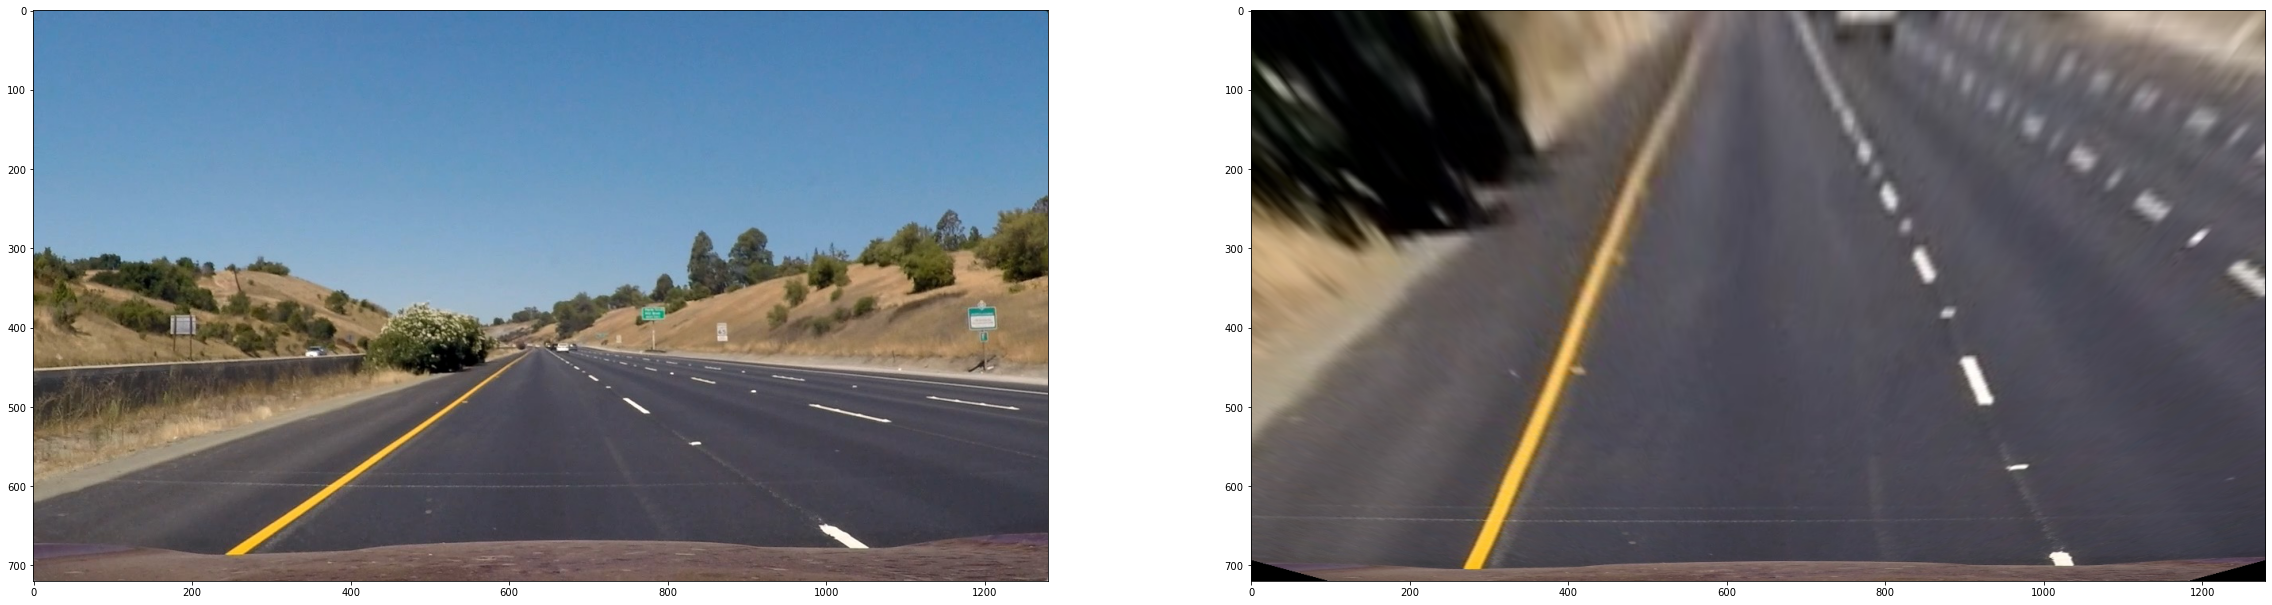

In [106]:
    
image = test_images[0]    
masked = get_lane_mask(image)    

print(image.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,30))
ax1.imshow(image)

# Choose an offset from image corners to plot detected corners
offset1 = 200 # offset for dst points x value
offset2 = 0 # offset for dst points bottom y value
offset3 = 0 # offset for dst points top y value
# Grab the image shape

img_size = (image.shape[1],image.shape[0])
w, h = image.shape[1],image.shape[0]
print(img_size)
corners_on_image = ([550, 430], [w-550, 430], [w, h], [0, h])
corners_on_dst = ([200, 20], [w-200, 20], [w-100, h], [100, h])
# For source points I'm grabbing the outer four detected corners
src = np.float32(corners_on_image)
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 定义目标点
dst = np.float32(corners_on_dst)
# Given src and dst points, calculate the perspective transform matrix
Mper = cv2.getPerspectiveTransform(src, dst)#perspection matrix
Mper_inv = cv2.getPerspectiveTransform(dst, src)#inverse matrix
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(image, Mper, img_size)#对去畸变后的图像进行透视变换
ax2.imshow(warped)